In [0]:
# Common imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [0]:
# REPLACEMENT CELL A - load the table you uploaded
from pyspark.sql import functions as F
from pyspark.sql import Window
import pyspark.sql.types as T
import pandas as pd, numpy as np, datetime, matplotlib.pyplot as plt

# load uploaded user table (as you named it)
try:
    df_raw = spark.table("workspace.default.influencers_dataset")
    print("Loaded table: workspace.default.influencers_dataset")
except Exception as e:
    raise RuntimeError(f"Could not read workspace.default.influencers_dataset: {e}")

print("Records loaded:", df_raw.count())
display(df_raw.limit(5))


Loaded table: workspace.default.influencers_dataset
Records loaded: 3000


influencer_id,name,platform,niche,country,followers,following,follower_following_ratio,posts,account_creation_year,account_age_days,posting_freq_per_week,avg_likes,avg_comments,avg_views,engagement_rate,follower_growth_30d,bot_score,fraud_flag,sentiment_score,content_type,relevance_score,age_13_17_pct,age_18_24_pct,age_25_34_pct,age_35_44_pct,age_45_plus_pct,male_pct,female_pct,other_pct,estimated_cpa,estimated_roi_score
inf_100000,Blake Wang,Instagram,Travel,Kenya,34830,7955,4.38,32,2018,2668,6,420,64,1483,0.0133,721,0.349,0,0.75,Photo,0.151,0.114,0.253,0.251,0.074,0.308,0.301,0.694,0.004,1145.4,0.0
inf_100001,Alex Harris,Twitter,Food,Germany,11871,1695,7.0,354,2019,2528,3,243,37,897,0.0334,87,0.089,0,0.239,Text,0.188,0.011,0.086,0.138,0.091,0.674,0.734,0.264,0.002,559.51,0.016
inf_100002,Avery Nguyen,TikTok,Art,Kenya,22008,1236,17.81,207,2017,3203,3,810,92,23192,0.0272,1480,0.218,0,-0.047,Short,0.098,0.006,0.089,0.241,0.126,0.537,0.517,0.479,0.004,338.43,0.056
inf_100003,Morgan Garcia,YouTube,Entertainment,United Kingdom,995,166,5.99,91,2016,3521,3,18,2,360,0.0215,12,0.673,0,-0.211,Long-form,0.285,0.018,0.213,0.341,0.22,0.207,0.594,0.405,0.0,613.23,0.046
inf_100004,Dakota Wang,Instagram,Parenting,Brazil,44421,11254,3.95,139,2019,2284,7,788,131,2820,0.0192,-1701,0.283,0,-0.202,Photo,0.048,0.031,0.163,0.396,0.129,0.281,0.588,0.409,0.003,427.3,0.0


In [0]:
# REPLACEMENT CELL B2 - create DB and write bronze as managed Delta table (serverless-safe)
from pyspark.sql import functions as F

db_name = "influencer_capstone"
spark.sql(f"CREATE DATABASE IF NOT EXISTS {db_name}")
spark.sql(f"USE {db_name}")

df_bronze = df_raw.withColumn("ingest_ts", F.current_timestamp()) \
                  .withColumn("source_table", F.lit("workspace.default.influencers_dataset"))

# Save as managed Delta table
(df_bronze.write
 .format("delta")
 .mode("overwrite")
 .option("overwriteSchema","true")
 .saveAsTable(f"{db_name}.bronze_influencers"))  # Managed table

# Use spark.catalog.refreshTable to update driver catalog (works from Python API on serverless)
try:
    spark.catalog.refreshTable(f"{db_name}.bronze_influencers")
except Exception as e:
    # If refreshTable is not necessary or fails, it's safe to continue; we'll read directly.
    print("spark.catalog.refreshTable failed or not needed:", e)

# Read to validate
bronze_count = spark.table(f"{db_name}.bronze_influencers").count()
print("Bronze (managed table) saved as:", f"{db_name}.bronze_influencers")
print("Bronze count:", bronze_count)
display(spark.table(f"{db_name}.bronze_influencers").limit(5))


spark.catalog.refreshTable failed or not needed: [NOT_SUPPORTED_WITH_SERVERLESS] REFRESH TABLE is not supported on serverless compute. SQLSTATE: 0A000

JVM stacktrace:
org.apache.spark.sql.AnalysisException
	at com.databricks.serverless.ServerlessGCEdgeCheck$.throwError(ServerlessGCEdgeCheck.scala:65)
	at com.databricks.serverless.ServerlessGCEdgeCheck$.checkBlockCacheCommand(ServerlessGCEdgeCheck.scala:43)
	at org.apache.spark.sql.connect.planner.SparkConnectPlanner.transformRefreshTable(SparkConnectPlanner.scala:4843)
	at org.apache.spark.sql.connect.planner.SparkConnectPlanner.transformCatalog(SparkConnectPlanner.scala:386)
	at org.apache.spark.sql.connect.planner.SparkConnectPlanner.$anonfun$transformRelation$2(SparkConnectPlanner.scala:311)
	at com.databricks.util.LexicalThreadLocal$Handle.runWith(LexicalThreadLocal.scala:63)
	at org.apache.spark.sql.connect.planner.SparkConnectPlanner.$anonfun$transformRelation$1(SparkConnectPlanner.scala:298)
	at org.apache.spark.sql.connect.ser

influencer_id,name,platform,niche,country,followers,following,follower_following_ratio,posts,account_creation_year,account_age_days,posting_freq_per_week,avg_likes,avg_comments,avg_views,engagement_rate,follower_growth_30d,bot_score,fraud_flag,sentiment_score,content_type,relevance_score,age_13_17_pct,age_18_24_pct,age_25_34_pct,age_35_44_pct,age_45_plus_pct,male_pct,female_pct,other_pct,estimated_cpa,estimated_roi_score,ingest_ts,source_table
inf_100000,Blake Wang,Instagram,Travel,Kenya,34830,7955,4.38,32,2018,2668,6,420,64,1483,0.0133,721,0.349,0,0.75,Photo,0.151,0.114,0.253,0.251,0.074,0.308,0.301,0.694,0.004,1145.4,0.0,2025-11-10T14:45:54.255Z,workspace.default.influencers_dataset
inf_100001,Alex Harris,Twitter,Food,Germany,11871,1695,7.0,354,2019,2528,3,243,37,897,0.0334,87,0.089,0,0.239,Text,0.188,0.011,0.086,0.138,0.091,0.674,0.734,0.264,0.002,559.51,0.016,2025-11-10T14:45:54.255Z,workspace.default.influencers_dataset
inf_100002,Avery Nguyen,TikTok,Art,Kenya,22008,1236,17.81,207,2017,3203,3,810,92,23192,0.0272,1480,0.218,0,-0.047,Short,0.098,0.006,0.089,0.241,0.126,0.537,0.517,0.479,0.004,338.43,0.056,2025-11-10T14:45:54.255Z,workspace.default.influencers_dataset
inf_100003,Morgan Garcia,YouTube,Entertainment,United Kingdom,995,166,5.99,91,2016,3521,3,18,2,360,0.0215,12,0.673,0,-0.211,Long-form,0.285,0.018,0.213,0.341,0.22,0.207,0.594,0.405,0.0,613.23,0.046,2025-11-10T14:45:54.255Z,workspace.default.influencers_dataset
inf_100004,Dakota Wang,Instagram,Parenting,Brazil,44421,11254,3.95,139,2019,2284,7,788,131,2820,0.0192,-1701,0.283,0,-0.202,Photo,0.048,0.031,0.163,0.396,0.129,0.281,0.588,0.409,0.003,427.3,0.0,2025-11-10T14:45:54.255Z,workspace.default.influencers_dataset


In [0]:
# REPLACEMENT CELL C2 - Bronze -> Silver, serverless-safe
from pyspark.sql import functions as F

bronze = spark.table(f"{db_name}.bronze_influencers")

silver = (bronze
          .dropDuplicates(["influencer_id"])
          .withColumn("platform", F.initcap(F.trim(F.col("platform"))))
          .withColumn("niche", F.initcap(F.trim(F.col("niche"))))
          .withColumn("followers", F.coalesce(F.col("followers").cast("long"), F.lit(0)))
          .withColumn("following", F.coalesce(F.col("following").cast("long"), F.lit(0)))
          .withColumn("posts", F.coalesce(F.col("posts").cast("int"), F.lit(0)))
          .withColumn("avg_likes", F.coalesce(F.col("avg_likes").cast("long"), F.lit(0)))
          .withColumn("avg_comments", F.coalesce(F.col("avg_comments").cast("long"), F.lit(0)))
          .withColumn("avg_views", F.coalesce(F.col("avg_views").cast("long"), F.lit(0)))
          .withColumn("engagement_rate",
                      F.coalesce(F.col("engagement_rate").cast("double"),
                                 ((F.col("avg_likes") + F.col("avg_comments"))/
                                  F.when(F.col("followers")>0, F.col("followers")).otherwise(F.lit(1))).cast("double")))
          .withColumn("follower_following_ratio",
                      F.when(F.col("following")>0, (F.col("followers")/F.col("following")).cast("double")).otherwise(F.lit(None)))
         )

# Save silver as managed table
(silver.write
       .format("delta")
       .mode("overwrite")
       .option("overwriteSchema","true")
       .saveAsTable(f"{db_name}.silver_influencers"))

# Try to refresh catalog; if not available, ignore.
try:
    spark.catalog.refreshTable(f"{db_name}.silver_influencers")
except Exception as e:
    print("catalog.refreshTable not necessary or failed:", e)

# Validate read
print("Silver count:", spark.table(f"{db_name}.silver_influencers").count())
display(spark.table(f"{db_name}.silver_influencers").limit(5))


catalog.refreshTable not necessary or failed: [NOT_SUPPORTED_WITH_SERVERLESS] REFRESH TABLE is not supported on serverless compute. SQLSTATE: 0A000

JVM stacktrace:
org.apache.spark.sql.AnalysisException
	at com.databricks.serverless.ServerlessGCEdgeCheck$.throwError(ServerlessGCEdgeCheck.scala:65)
	at com.databricks.serverless.ServerlessGCEdgeCheck$.checkBlockCacheCommand(ServerlessGCEdgeCheck.scala:43)
	at org.apache.spark.sql.connect.planner.SparkConnectPlanner.transformRefreshTable(SparkConnectPlanner.scala:4843)
	at org.apache.spark.sql.connect.planner.SparkConnectPlanner.transformCatalog(SparkConnectPlanner.scala:386)
	at org.apache.spark.sql.connect.planner.SparkConnectPlanner.$anonfun$transformRelation$2(SparkConnectPlanner.scala:311)
	at com.databricks.util.LexicalThreadLocal$Handle.runWith(LexicalThreadLocal.scala:63)
	at org.apache.spark.sql.connect.planner.SparkConnectPlanner.$anonfun$transformRelation$1(SparkConnectPlanner.scala:298)
	at org.apache.spark.sql.connect.servic

influencer_id,name,platform,niche,country,followers,following,follower_following_ratio,posts,account_creation_year,account_age_days,posting_freq_per_week,avg_likes,avg_comments,avg_views,engagement_rate,follower_growth_30d,bot_score,fraud_flag,sentiment_score,content_type,relevance_score,age_13_17_pct,age_18_24_pct,age_25_34_pct,age_35_44_pct,age_45_plus_pct,male_pct,female_pct,other_pct,estimated_cpa,estimated_roi_score,ingest_ts,source_table
inf_102531,Dakota Anderson,Tiktok,Finance,Indonesia,66418,12935,5.134750676459219,101,2018,2746,8,896,144,24312,0.0165,-1135,0.321,0,-0.354,Short,0.134,0.026,0.118,0.387,0.018,0.45,0.863,0.134,0.004,2370.47,0.0,2025-11-10T14:45:54.255Z,workspace.default.influencers_dataset
inf_102813,Riley Perez,Instagram,Travel,United Kingdom,6554,728,9.002747252747254,107,2019,2445,5,115,15,286,0.0239,194,0.261,0,-0.075,Photo,0.219,0.072,0.11,0.166,0.176,0.475,0.261,0.738,0.001,5000.0,0.0,2025-11-10T14:45:54.255Z,workspace.default.influencers_dataset
inf_101296,Lee Robinson,Instagram,Beauty,Canada,9664,1775,5.444507042253521,118,2024,455,5,152,12,299,0.0205,613,0.185,0,-0.27,Photo,0.514,0.038,0.255,0.08,0.044,0.582,0.462,0.538,0.0,650.53,0.019,2025-11-10T14:45:54.255Z,workspace.default.influencers_dataset
inf_101594,Harper Martinez,Tiktok,Beauty,United Kingdom,3811,1054,3.6157495256166983,17,2020,2114,2,93,7,5899,0.031,-131,0.231,0,0.189,Short,0.232,0.02,0.175,0.174,0.071,0.56,0.407,0.59,0.003,2394.03,0.01,2025-11-10T14:45:54.255Z,workspace.default.influencers_dataset
inf_102343,Skyler Lopez,Instagram,Fitness,Spain,14844,3655,4.061285909712723,98,2019,2439,5,351,53,457,0.0209,589,0.195,0,-0.576,Carousel,0.811,0.022,0.124,0.116,0.125,0.613,0.47,0.525,0.005,1208.63,0.086,2025-11-10T14:45:54.255Z,workspace.default.influencers_dataset


In [0]:
# REPLACEMENT CELL D2 - Gold features and save as managed table (serverless-safe)
from pyspark.sql import functions as F

silver = spark.table(f"{db_name}.silver_influencers")

gold = (silver
        .withColumn("log_followers", F.log1p(F.col("followers")))
        .withColumn("engagement_per_post", ((F.col("avg_likes") + F.col("avg_comments"))/F.greatest(F.col("posts"), F.lit(1))).cast("double"))
        .withColumn("recency_score", F.when(F.col("follower_growth_30d")>0, (F.col("follower_growth_30d")/F.greatest(F.col("followers"), F.lit(1))).cast("double")).otherwise(F.lit(0.0)))
        .withColumn("is_potential_bot", F.when((F.col("bot_score")>0.7) | (F.col("fraud_flag")==1) | (F.col("engagement_rate")<0.002), F.lit(1)).otherwise(F.lit(0)))
       )

(gold.write
     .format("delta")
     .mode("overwrite")
     .option("overwriteSchema","true")
     .saveAsTable(f"{db_name}.gold_influencer_features"))

try:
    spark.catalog.refreshTable(f"{db_name}.gold_influencer_features")
except Exception as e:
    print("catalog.refreshTable not necessary or failed:", e)

print("Gold count:", spark.table(f"{db_name}.gold_influencer_features").count())
display(spark.table(f"{db_name}.gold_influencer_features").limit(5))


catalog.refreshTable not necessary or failed: [NOT_SUPPORTED_WITH_SERVERLESS] REFRESH TABLE is not supported on serverless compute. SQLSTATE: 0A000

JVM stacktrace:
org.apache.spark.sql.AnalysisException
	at com.databricks.serverless.ServerlessGCEdgeCheck$.throwError(ServerlessGCEdgeCheck.scala:65)
	at com.databricks.serverless.ServerlessGCEdgeCheck$.checkBlockCacheCommand(ServerlessGCEdgeCheck.scala:43)
	at org.apache.spark.sql.connect.planner.SparkConnectPlanner.transformRefreshTable(SparkConnectPlanner.scala:4843)
	at org.apache.spark.sql.connect.planner.SparkConnectPlanner.transformCatalog(SparkConnectPlanner.scala:386)
	at org.apache.spark.sql.connect.planner.SparkConnectPlanner.$anonfun$transformRelation$2(SparkConnectPlanner.scala:311)
	at com.databricks.util.LexicalThreadLocal$Handle.runWith(LexicalThreadLocal.scala:63)
	at org.apache.spark.sql.connect.planner.SparkConnectPlanner.$anonfun$transformRelation$1(SparkConnectPlanner.scala:298)
	at org.apache.spark.sql.connect.servic

influencer_id,name,platform,niche,country,followers,following,follower_following_ratio,posts,account_creation_year,account_age_days,posting_freq_per_week,avg_likes,avg_comments,avg_views,engagement_rate,follower_growth_30d,bot_score,fraud_flag,sentiment_score,content_type,relevance_score,age_13_17_pct,age_18_24_pct,age_25_34_pct,age_35_44_pct,age_45_plus_pct,male_pct,female_pct,other_pct,estimated_cpa,estimated_roi_score,ingest_ts,source_table,log_followers,engagement_per_post,recency_score,is_potential_bot
inf_102531,Dakota Anderson,Tiktok,Finance,Indonesia,66418,12935,5.134750676459219,101,2018,2746,8,896,144,24312,0.0165,-1135,0.321,0,-0.354,Short,0.134,0.026,0.118,0.387,0.018,0.45,0.863,0.134,0.004,2370.47,0.0,2025-11-10T14:45:54.255Z,workspace.default.influencers_dataset,11.103738439111286,10.297029702970297,0.0,0
inf_102813,Riley Perez,Instagram,Travel,United Kingdom,6554,728,9.002747252747254,107,2019,2445,5,115,15,286,0.0239,194,0.261,0,-0.075,Photo,0.219,0.072,0.11,0.166,0.176,0.475,0.261,0.738,0.001,5000.0,0.0,2025-11-10T14:45:54.255Z,workspace.default.influencers_dataset,8.7879833961978,1.2149532710280373,0.029600244125724748,0
inf_101296,Lee Robinson,Instagram,Beauty,Canada,9664,1775,5.444507042253521,118,2024,455,5,152,12,299,0.0205,613,0.185,0,-0.27,Photo,0.514,0.038,0.255,0.08,0.044,0.582,0.462,0.538,0.0,650.53,0.019,2025-11-10T14:45:54.255Z,workspace.default.influencers_dataset,9.17626639164243,1.3898305084745763,0.06343129139072848,0
inf_101594,Harper Martinez,Tiktok,Beauty,United Kingdom,3811,1054,3.6157495256166983,17,2020,2114,2,93,7,5899,0.031,-131,0.231,0,0.189,Short,0.232,0.02,0.175,0.174,0.071,0.56,0.407,0.59,0.003,2394.03,0.01,2025-11-10T14:45:54.255Z,workspace.default.influencers_dataset,8.245909264774093,5.882352941176471,0.0,0
inf_102343,Skyler Lopez,Instagram,Fitness,Spain,14844,3655,4.061285909712723,98,2019,2439,5,351,53,457,0.0209,589,0.195,0,-0.576,Carousel,0.811,0.022,0.124,0.116,0.125,0.613,0.47,0.525,0.005,1208.63,0.086,2025-11-10T14:45:54.255Z,workspace.default.influencers_dataset,9.60541838719786,4.122448979591836,0.03967933171651846,0


In [0]:
# REPLACEMENT CELL E2 - Generate synthetic post-level 90 days for a sample and save as managed table
import numpy as np, pandas as pd, datetime

gold_pdf = spark.table(f"{db_name}.gold_influencer_features").toPandas()
sample_n = min(300, len(gold_pdf))
sample_infs = gold_pdf.sample(n=sample_n, random_state=42).reset_index(drop=True)

n_days = 90
start_date = datetime.date.today() - datetime.timedelta(days=n_days-1)
rows = []
for _, r in sample_infs.iterrows():
    avg_posts_per_day = max(0.2, r.get('posting_freq_per_week',1)/7.0)
    for d in range(n_days):
        date = start_date + datetime.timedelta(days=d)
        num_posts = np.random.poisson(avg_posts_per_day)
        for _ in range(num_posts):
            likes = int(max(0, np.random.normal(loc=r['avg_likes'] if r['avg_likes']>0 else 10, scale=max(1, (r['avg_likes'] if r['avg_likes']>0 else 10)*0.2))))
            comments = int(max(0, np.random.normal(loc=r['avg_comments'] if r['avg_comments']>0 else 2, scale=max(1,(r['avg_comments'] if r['avg_comments']>0 else 2)*0.3))))
            views = int(max(1, np.random.normal(loc=r['avg_views'] if r['avg_views']>0 else likes*3, scale=max(1,(r['avg_views'] if r['avg_views']>0 else likes*3)*0.25))))
            hashtag = r['niche'].lower().replace(" ","") + "_" + str(np.random.randint(1,6))
            sentiment = float(np.clip(np.random.normal(loc=r.get('sentiment_score',0), scale=0.2), -1, 1))
            rows.append({
                "influencer_id": r['influencer_id'],
                "date": date.isoformat(),
                "likes": likes,
                "comments": comments,
                "views": views,
                "hashtag": hashtag,
                "sentiment": sentiment
            })

posts_df = pd.DataFrame(rows)
print("Generated post rows:", len(posts_df))

# Save posts DataFrame as a MANAGED Delta table (posts_90d)
spark_posts = spark.createDataFrame(posts_df)
(spark_posts.write
           .format("delta")
           .mode("overwrite")
           .option("overwriteSchema","true")
           .saveAsTable(f"{db_name}.posts_90d"))

try:
    spark.catalog.refreshTable(f"{db_name}.posts_90d")
except Exception as e:
    print("catalog.refreshTable not necessary or failed:", e)

print("posts_90d saved as managed table:", f"{db_name}.posts_90d")
display(spark.table(f"{db_name}.posts_90d").limit(5))


Generated post rows: 16644
catalog.refreshTable not necessary or failed: [NOT_SUPPORTED_WITH_SERVERLESS] REFRESH TABLE is not supported on serverless compute. SQLSTATE: 0A000

JVM stacktrace:
org.apache.spark.sql.AnalysisException
	at com.databricks.serverless.ServerlessGCEdgeCheck$.throwError(ServerlessGCEdgeCheck.scala:65)
	at com.databricks.serverless.ServerlessGCEdgeCheck$.checkBlockCacheCommand(ServerlessGCEdgeCheck.scala:43)
	at org.apache.spark.sql.connect.planner.SparkConnectPlanner.transformRefreshTable(SparkConnectPlanner.scala:4843)
	at org.apache.spark.sql.connect.planner.SparkConnectPlanner.transformCatalog(SparkConnectPlanner.scala:386)
	at org.apache.spark.sql.connect.planner.SparkConnectPlanner.$anonfun$transformRelation$2(SparkConnectPlanner.scala:311)
	at com.databricks.util.LexicalThreadLocal$Handle.runWith(LexicalThreadLocal.scala:63)
	at org.apache.spark.sql.connect.planner.SparkConnectPlanner.$anonfun$transformRelation$1(SparkConnectPlanner.scala:298)
	at org.apac

influencer_id,date,likes,comments,views,hashtag,sentiment
inf_100147,2025-09-30,64,12,2045,entertainment_1,0.1731981531808626
inf_100147,2025-10-02,66,12,2134,entertainment_1,0.4037876443539717
inf_100147,2025-10-03,71,13,1970,entertainment_4,-0.09819112401729843
inf_100147,2025-10-04,82,9,1897,entertainment_5,0.123458779931476
inf_100147,2025-10-05,66,11,2161,entertainment_3,-0.1910447449581257


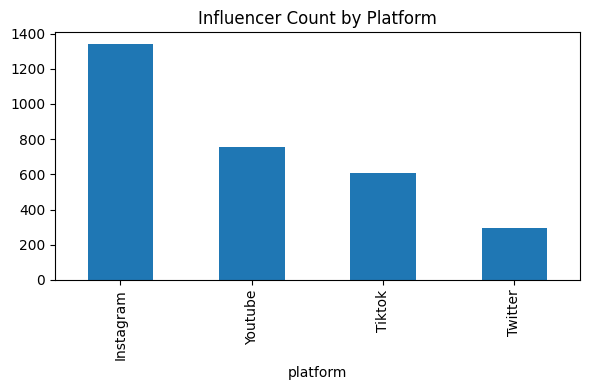

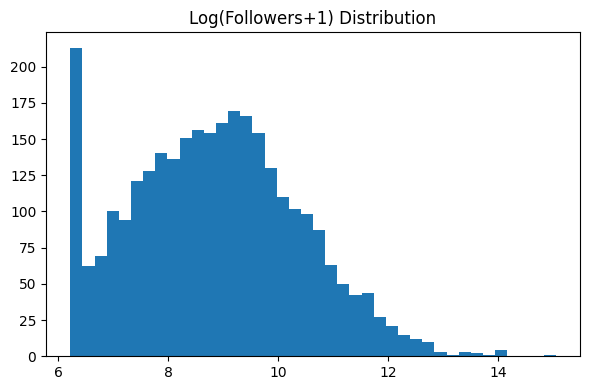

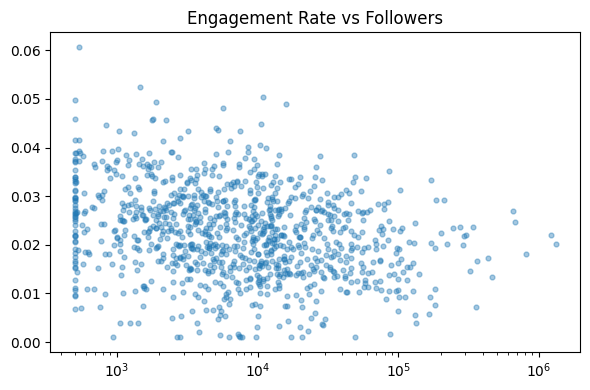

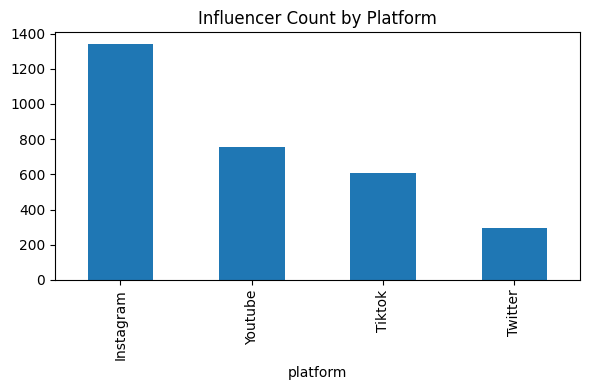

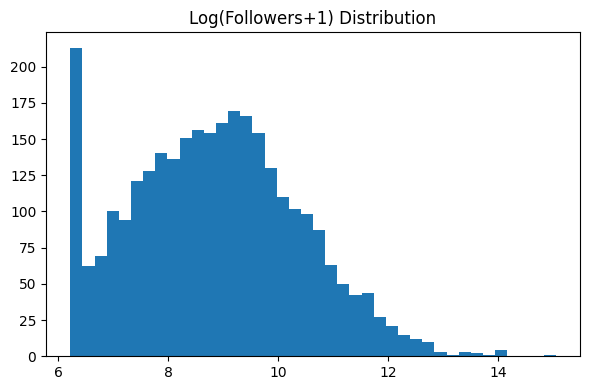

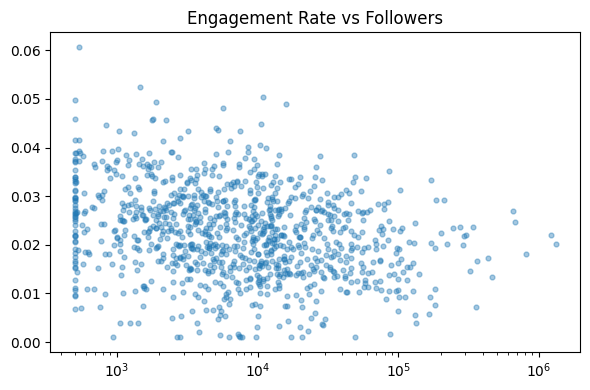

In [0]:
# REPLACEMENT CELL F2 - EDA using the managed tables created above
import matplotlib.pyplot as plt
import numpy as np

gold_pdf = spark.table(f"{db_name}.gold_influencer_features").toPandas()

# Platform distribution plot
plt.figure(figsize=(6,4))
gold_pdf['platform'].value_counts().plot(kind='bar')
plt.title("Influencer Count by Platform"); plt.tight_layout()
display(plt.gcf())

# Followers distribution (log)
plt.figure(figsize=(6,4))
plt.hist(np.log1p(gold_pdf['followers']), bins=40)
plt.title("Log(Followers+1) Distribution"); plt.tight_layout()
display(plt.gcf())

# Engagement vs followers scatter (sample)
sample = gold_pdf.sample(n=min(1000, len(gold_pdf)), random_state=42)
plt.figure(figsize=(6,4))
plt.scatter(sample['followers'], sample['engagement_rate'], alpha=0.4, s=12)
plt.xscale('log')
plt.title("Engagement Rate vs Followers"); plt.tight_layout()
display(plt.gcf())


In [0]:
# COMMON: run once at top of notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, classification_report, roc_auc_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

# Spark shorthand
from pyspark.sql import functions as F


USE CASE - 1: Influencer Selection & Scoring System
(Weighted score + learned ranking (GBR), output top candidates & visualization)

Top 10 influencers by weighted score:


influencer_id,name,platform,niche,followers,engagement_rate,relevance_score,is_potential_bot,weighted_score
inf_100891,Jules Lewis,Tiktok,Lifestyle,725713,0.0222,0.738,0,0.5600540822490576
inf_101177,Jamie Miller,Instagram,Tech,174733,0.0354,0.557,0,0.5354841668205673
inf_101876,Riley Jackson,Youtube,Photography,175939,0.0232,0.713,0,0.5038710644102944
inf_101478,Jules Smith,Tiktok,Fashion,48849,0.0384,0.546,0,0.49865227659307726
inf_102237,Quinn Moore,Instagram,Fitness,27795,0.0383,0.647,0,0.49738864587043063
inf_100769,Charlie Hall,Tiktok,Travel,104205,0.0379,0.412,0,0.4973203912685868
inf_102686,Blake Lewis,Instagram,Lifestyle,210769,0.0255,0.591,0,0.4972170899277588
inf_102530,Jordan Nguyen,Youtube,Health,43383,0.0379,0.552,0,0.4925564843552852
inf_101764,Morgan Nguyen,Instagram,Health,86663,0.0249,0.741,0,0.49088989018462903
inf_101755,Cameron Brown,Tiktok,Gaming,10878,0.0504,0.464,0,0.4857658168616833


Databricks visualization. Run in Databricks to view.

Learned GBR MAE: 0.024815343035987102
Top 10 by predicted ROI:


/databricks/python/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


influencer_id,name,platform,niche,followers,engagement_rate,predicted_roi
inf_100444,Robin Lopez,Tiktok,Art,7011,0.0178,0.11343556613586689
inf_102000,Taylor Davis,Instagram,Fitness,500,0.0102,0.11156841840613531
inf_101443,Robin Martinez,Instagram,Fashion,4347,0.0278,0.10566965870246099
inf_102849,Skyler Wilson,Instagram,Fitness,28098,0.0166,0.1050744228427184
inf_101226,Jamie Miller,Instagram,Finance,1687,0.0251,0.10236295714905173
inf_101033,Sam Martinez,Instagram,Beauty,33042,0.0209,0.09836935795517152
inf_101592,Riley Gonzalez,Instagram,Tech,2458,0.0218,0.0935135111170666
inf_101536,Skyler Walker,Instagram,Art,500,0.0412,0.09207925369111054
inf_102045,Skyler Clark,Tiktok,Finance,840,0.0527,0.08760204351433497
inf_101795,Sam Lopez,Instagram,Travel,500,0.0154,0.08701397490215085


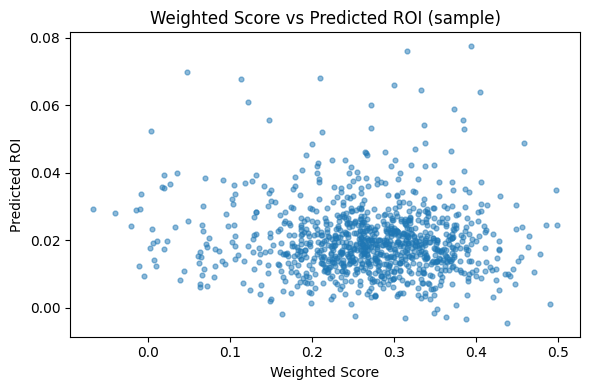

In [0]:
# UC1: Influencer Selection & Scoring System
# Reads: influencer_capstone.gold_influencer_features

# 1. Load gold table
gold_spark = spark.table("influencer_capstone.gold_influencer_features")
gold = gold_spark.toPandas().fillna(0)

# 2. Normalizations for weighted score
gold['log_followers'] = np.log1p(gold['followers'].astype(float))
gold['norm_followers'] = (gold['log_followers'] - gold['log_followers'].min()) / (gold['log_followers'].max() - gold['log_followers'].min() + 1e-9)
gold['norm_engagement'] = (gold['engagement_rate'] - gold['engagement_rate'].min()) / (gold['engagement_rate'].max() - gold['engagement_rate'].min() + 1e-9)
gold['norm_relevance'] = (gold['relevance_score'] - gold['relevance_score'].min()) / (gold['relevance_score'].max() - gold['relevance_score'].min() + 1e-9)

# 3. Weighted scoring (configurable)
w_reach, w_eng, w_rel, w_safety = 0.35, 0.35, 0.2, 0.1
gold['weighted_score'] = (w_reach*gold['norm_followers'] + w_eng*gold['norm_engagement'] + w_rel*gold['norm_relevance'] - w_safety*gold['is_potential_bot'])

# 4. Display top 10 by weighted score
top_weighted = gold.sort_values('weighted_score', ascending=False).head(10)
print("Top 10 influencers by weighted score:")
display(top_weighted[['influencer_id','name','platform','niche','followers','engagement_rate','relevance_score','is_potential_bot','weighted_score']])

# 5. Learned ranking: predict estimated_roi_score (proxy) with GBR
features = ['log_followers','engagement_per_post','recency_score','relevance_score','bot_score','sentiment_score','posting_freq_per_week']
df_ml = gold.copy()
df_ml = df_ml.dropna(subset=features + ['estimated_roi_score'])
if len(df_ml) < 30:
    print("Warning: not enough rows to train learned model robustly (need >=30). Showing weighted results only.")
else:
    X = df_ml[features].values
    y = df_ml['estimated_roi_score'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    gbr = GradientBoostingRegressor(n_estimators=200, max_depth=4, random_state=42)
    gbr.fit(X_train, y_train)
    print("Learned GBR MAE:", mean_absolute_error(y_test, gbr.predict(X_test)))
    df_ml['predicted_roi'] = gbr.predict(df_ml[features])
    top_pred = df_ml.sort_values('predicted_roi', ascending=False).head(10)
    print("Top 10 by predicted ROI:")
    display(top_pred[['influencer_id','name','platform','niche','followers','engagement_rate','predicted_roi']])

# 6. Visual: weighted_score vs predicted ROI (use sample to keep plot readable)
if 'predicted_roi' in df_ml.columns and len(df_ml) > 0:
    sample = df_ml.sample(n=min(1000,len(df_ml)), random_state=42)
    plt.figure(figsize=(6,4))
    plt.scatter(sample['weighted_score'], sample['predicted_roi'], alpha=0.5, s=12)
    plt.xlabel('Weighted Score'); plt.ylabel('Predicted ROI')
    plt.title('Weighted Score vs Predicted ROI (sample)')
    plt.tight_layout()
    display(plt.gcf())
    plt.close()
else:
    print("Skipping scatter: predicted_roi not available.")


USE CASE 2 — Campaign Impact Measurement & ROI Analysis

(Simulate campaigns, allocate budget, compute simple attribution and ROI per influencer + visuals)

Campaign aggregates:


campaign_id,spend,conversions,revenue,roi
camp_A,24999.999975822047,43.62476373190607,2181.238186595304,-0.9127504724517708
camp_B,17999.999980176213,26.784295687452772,1339.2147843726386,-0.9255991785639739
camp_C,14999.999986945166,33.642684731450274,1682.1342365725138,-0.8878577174641733


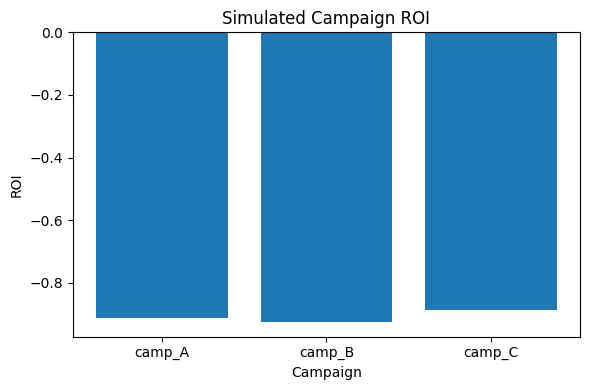

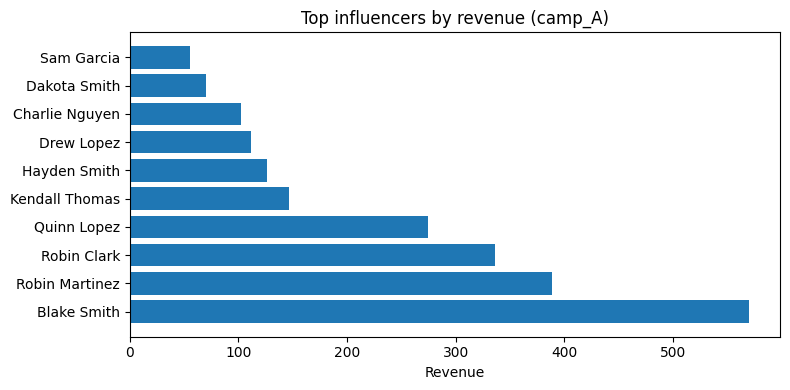

In [0]:
# UC2: Campaign Impact Measurement & ROI Analysis (synthetic simulation)
gold = spark.table("influencer_capstone.gold_influencer_features").toPandas().fillna(0)

# ensure predicted_roi exists (if created in UC1)
if 'predicted_roi' not in gold.columns:
    gold['predicted_roi'] = gold.get('estimated_roi_score', 0.0)

campaigns = [
    {"campaign_id":"camp_A","brand":"BrandA","budget":25000,"target_niche":"Fashion"},
    {"campaign_id":"camp_B","brand":"BrandB","budget":18000,"target_niche":"Tech"},
    {"campaign_id":"camp_C","brand":"BrandC","budget":15000,"target_niche":"Food"}
]

rows = []
for c in campaigns:
    # choose candidates from niche; fallback to all if too few
    candidates = gold[gold['niche']==c['target_niche']].copy()
    if len(candidates) < 10:
        candidates = gold.copy()
    top = candidates.sort_values('predicted_roi', ascending=False).head(10)
    scores = top['predicted_roi'].values
    if scores.sum() <= 0:
        weights = np.ones(len(scores)) / len(scores)
    else:
        weights = scores / (scores.sum() + 1e-9)
    for idx, (_, row) in enumerate(top.iterrows()):
        spend = float(weights[idx]) * c['budget']
        est_cpa = max(1.0, float(row.get('estimated_cpa', 100.0)))
        uplift = 1.0 + float(row.get('engagement_rate', 0.0)) * 10.0
        conversions = (spend / est_cpa) * uplift
        avg_order_value = 50.0
        revenue = conversions * avg_order_value
        roi = (revenue - spend) / (spend + 1e-9)
        rows.append({
            "campaign_id": c['campaign_id'],
            "brand": c['brand'],
            "influencer_id": row['influencer_id'],
            "name": row['name'],
            "spend": spend,
            "conversions": conversions,
            "revenue": revenue,
            "roi": roi
        })

res_df = pd.DataFrame(rows)
agg = res_df.groupby('campaign_id').agg({'spend':'sum','conversions':'sum','revenue':'sum'}).reset_index()
agg['roi'] = (agg['revenue'] - agg['spend']) / (agg['spend'] + 1e-9)
print("Campaign aggregates:")
display(agg)

# Plot ROI per campaign
plt.figure(figsize=(6,4))
plt.bar(agg['campaign_id'], agg['roi'])
plt.title('Simulated Campaign ROI')
plt.ylabel('ROI')
plt.xlabel('Campaign')
plt.tight_layout()
display(plt.gcf())
plt.close()

# Plot top influencers by revenue for camp_A (if present)
if 'camp_A' in agg['campaign_id'].values:
    campA = res_df[res_df['campaign_id']=='camp_A'].sort_values('revenue', ascending=False).head(10)
    plt.figure(figsize=(8,4))
    plt.barh(campA['name'], campA['revenue'])
    plt.title('Top influencers by revenue (camp_A)')
    plt.xlabel('Revenue')
    plt.tight_layout()
    display(plt.gcf())
    plt.close()


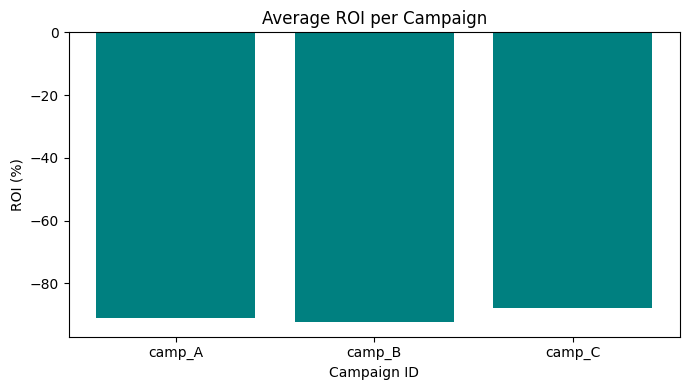

In [0]:
# Compute ROI (%) from your simulated campaign data
res_df['roi_percent'] = ((res_df['revenue'] - res_df['spend']) / res_df['spend']) * 100

# Aggregate ROI by campaign
roi_by_campaign = res_df.groupby('campaign_id')['roi_percent'].mean().reset_index()

# Plot the bar chart
plt.figure(figsize=(7,4))
plt.bar(roi_by_campaign['campaign_id'], roi_by_campaign['roi_percent'], color='teal')
plt.xlabel('Campaign ID')
plt.ylabel('ROI (%)')
plt.title('Average ROI per Campaign')
plt.tight_layout()
display(plt.gcf())
plt.close()


In [0]:
# Make sure you have the ROI column as a percentage
res_df = res_df.copy()

# If ROI is in decimal form (like 0.45 = 45%), convert to percentage
if 'roi' in res_df.columns:
    res_df['roi_percent'] = res_df['roi'] * 100
else:
    # Compute ROI if it wasn't already created
    res_df['roi_percent'] = ((res_df['revenue'] - res_df['spend']) / res_df['spend']) * 100

# Also calculate aggregated ROI by campaign for plotting
roi_by_campaign = res_df.groupby(['campaign_id','brand']).agg({
    'roi_percent':'mean',
    'spend':'sum',
    'revenue':'sum'
}).reset_index()

display(roi_by_campaign)


campaign_id,brand,roi_percent,spend,revenue
camp_A,BrandA,-90.96609796360435,24999.999975822047,2181.238186595304
camp_B,BrandB,-92.34074303271902,17999.999980176213,1339.2147843726386
camp_C,BrandC,-87.86991367767799,14999.999986945166,1682.1342365725138


Databricks visualization. Run in Databricks to view.

USE CASE 3 — Audience Sentiment & Trend Prediction

(Aggregates sentiment by niche and detects hashtag spikes (z-score). Plots mean sentiment by niche and top hashtag trends)

Mean sentiment by niche:


niche
Education        0.212619
Fashion          0.137616
Photography      0.135184
Parenting        0.129624
Entertainment    0.089302
Lifestyle        0.085684
Fitness          0.071368
Food             0.058556
Tech             0.051692
Health           0.051429
Name: mean_sentiment, dtype: float64

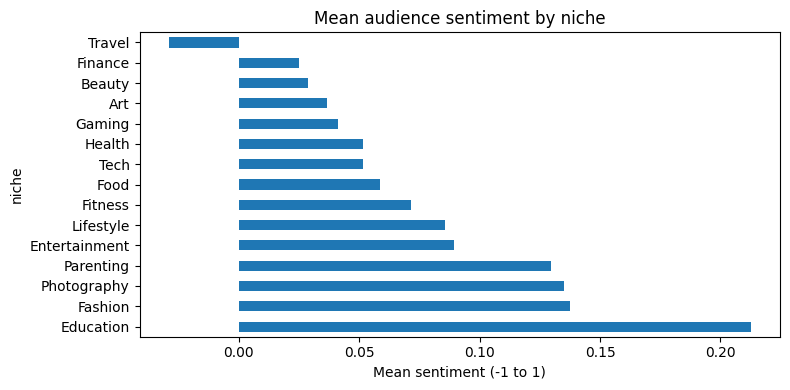

Recent hashtag spikes (date, hashtag):


date,hashtag
2025-11-10T00:00:00.000Z,entertainment_5
2025-11-08T00:00:00.000Z,art_5
2025-11-06T00:00:00.000Z,food_4
2025-11-05T00:00:00.000Z,parenting_1
2025-11-03T00:00:00.000Z,beauty_1
2025-10-31T00:00:00.000Z,photography_5
2025-10-31T00:00:00.000Z,food_2
2025-10-31T00:00:00.000Z,art_2
2025-10-29T00:00:00.000Z,entertainment_5
2025-10-27T00:00:00.000Z,entertainment_1


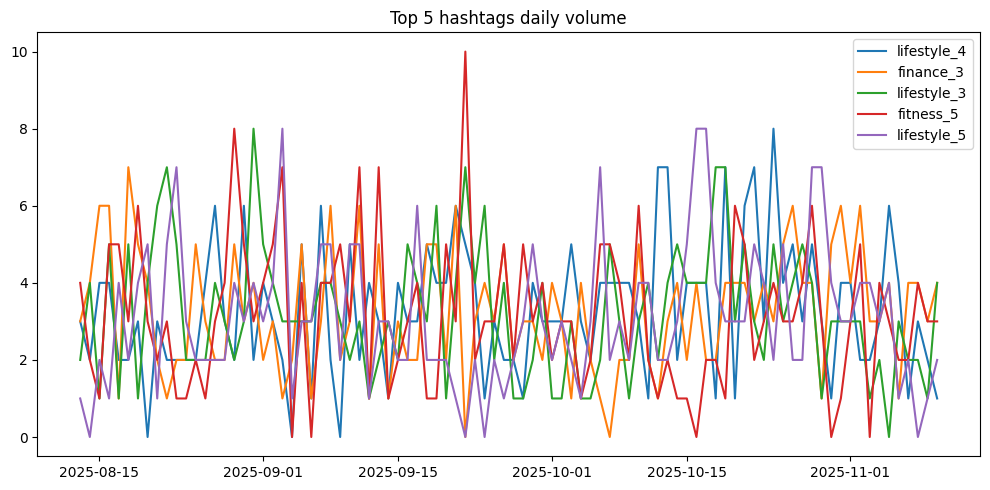

In [0]:
# UC3: Audience Sentiment & Trend Prediction
# requires influencer_capstone.posts_90d
try:
    posts_spark = spark.table("influencer_capstone.posts_90d")
    posts = posts_spark.toPandas()
except Exception as e:
    raise RuntimeError("posts_90d table not found. Run the synthetic posts generator cell before this one.") from e

posts['date'] = pd.to_datetime(posts['date'])

# 1) Sentiment aggregation by influencer -> niche
influencer_sent = posts.groupby('influencer_id')['sentiment'].mean().reset_index().rename(columns={'sentiment':'mean_sentiment'})
gold = spark.table("influencer_capstone.gold_influencer_features").toPandas().fillna(0)
sent_df = influencer_sent.merge(gold[['influencer_id','niche']], on='influencer_id', how='left')
niche_sent = sent_df.groupby('niche')['mean_sentiment'].mean().sort_values(ascending=False)
print("Mean sentiment by niche:")
display(niche_sent.head(10))

plt.figure(figsize=(8,4))
niche_sent.plot(kind='barh')
plt.title('Mean audience sentiment by niche')
plt.xlabel('Mean sentiment (-1 to 1)')
plt.tight_layout()
display(plt.gcf())
plt.close()

# 2) Trend detection by hashtag (daily volume + rolling z-score)
hashtag_vol = posts.groupby(['date','hashtag']).size().reset_index(name='count')
hashtag_ts = hashtag_vol.pivot(index='date', columns='hashtag', values='count').fillna(0)

# rolling mean/std (7-day)
rolling_mean = hashtag_ts.rolling(window=7, min_periods=1).mean()
rolling_std = hashtag_ts.rolling(window=7, min_periods=1).std().replace(0,1)
zscore = (hashtag_ts - rolling_mean) / rolling_std

# spikes where zscore > 2
spikes = (zscore > 2).stack().reset_index()
spikes.columns = ['date','hashtag','is_spike']
spike_events = spikes[spikes['is_spike']].sort_values('date', ascending=False).head(20)
print("Recent hashtag spikes (date, hashtag):")
display(spike_events[['date','hashtag']])

# Plot top 5 hashtags by total volume
top_hashtags = posts['hashtag'].value_counts().head(5).index.tolist()
plt.figure(figsize=(10,5))
for h in top_hashtags:
    ser = hashtag_ts[h]
    plt.plot(ser.index, ser.values, label=h)
plt.legend(); plt.title('Top 5 hashtags daily volume'); plt.tight_layout()
display(plt.gcf())
plt.close()


In [0]:
# Ensure you have posts data
posts = spark.table("influencer_capstone.posts_90d")

# Compute average sentiment and post count per hashtag per day
trend_df = (posts
    .groupBy("date", "hashtag")
    .agg(
        F.avg("sentiment").alias("avg_sentiment"),
        F.count("*").alias("post_count")
    )
    .orderBy("date")
)

display(trend_df)


date,hashtag,avg_sentiment,post_count
2025-08-13,tech_2,0.27083781640420324,2
2025-08-13,education_1,0.25914992451473384,4
2025-08-13,food_1,0.10377883722727199,2
2025-08-13,gaming_3,0.017471545270465166,3
2025-08-13,fashion_5,-0.10379273092836507,3
2025-08-13,art_3,0.002118908887258547,2
2025-08-13,fitness_3,0.27376148441948095,3
2025-08-13,beauty_3,-0.16763116818766757,5
2025-08-13,education_5,0.11219762642618433,1
2025-08-13,fashion_2,-0.08432740581975731,2


Databricks visualization. Run in Databricks to view.

USE CASE 4 — Fake Influencer & Bot Detection

(Train a baseline RandomForest classifier on gold features, evaluate, show feature importances and top flagged influencers)

Label distribution: {0: 2601, 1: 399}
Classifier evaluation (baseline RandomForest):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       650
           1       1.00      1.00      1.00       100

    accuracy                           1.00       750
   macro avg       1.00      1.00      1.00       750
weighted avg       1.00      1.00      1.00       750

ROC AUC: 1.0
Feature importances:


bot_score                   0.401113
avg_comments                0.301787
avg_likes                   0.111644
engagement_rate             0.060426
followers                   0.056285
recency_score               0.036839
follower_growth_30d         0.022014
follower_following_ratio    0.007531
posting_freq_per_week       0.002361
dtype: float64

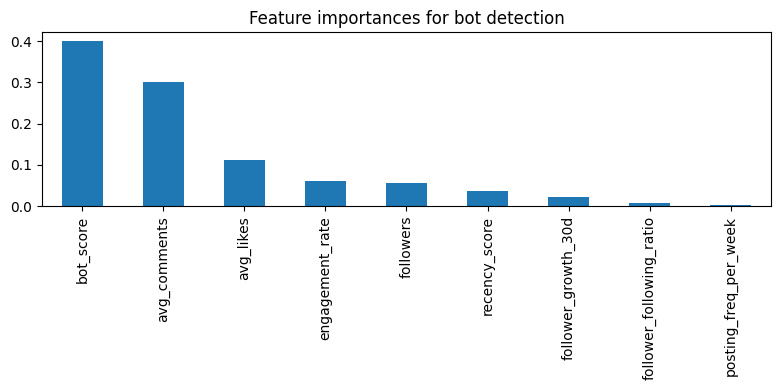

Top flagged accounts by predicted bot probability:


influencer_id,name,platform,followers,engagement_rate,bot_score,pred_bot_prob,is_potential_bot
inf_102285,Hayden Taylor,Instagram,500,0.0207,0.353,1.0,1
inf_100844,Cameron Patel,Instagram,548,0.0177,0.281,1.0,1
inf_101307,Drew Rodriguez,Tiktok,500,0.0101,0.234,1.0,1
inf_102675,Reese Moore,Instagram,886,0.0081,0.123,1.0,1
inf_101895,Robin Anderson,Tiktok,624,0.0186,0.12,1.0,1
inf_101104,Kai Lewis,Twitter,500,0.0174,0.135,1.0,1
inf_101101,Robin White,Twitter,594,0.0185,0.579,1.0,1
inf_100881,Lee Robinson,Youtube,500,0.0096,0.451,1.0,1
inf_100530,Emerson Robinson,Tiktok,500,0.0069,0.324,1.0,1
inf_102151,Kai Garcia,Instagram,734,0.0103,0.55,1.0,1


In [0]:
# UC4: Fake Influencer & Bot Detection (baseline classifier)
gold_df = spark.table("influencer_capstone.gold_influencer_features").toPandas().fillna(0)

# features and label
label_col = 'is_potential_bot'
feat_cols = ['followers','engagement_rate','follower_growth_30d','follower_following_ratio','avg_comments','avg_likes','posting_freq_per_week','recency_score','bot_score']
df_model = gold_df[feat_cols + [label_col]].copy().fillna(0)

# check label distribution
counts = df_model[label_col].value_counts().to_dict()
print("Label distribution:", counts)

# prepare data
X = df_model[feat_cols].values
y = df_model[label_col].values
if len(set(y))==1:
    raise RuntimeError("All labels are identical (no positive/negative examples). Cannot train classifier. Use is_potential_bot as noisy label or produce manual labels.")
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42,stratify=y if len(np.unique(y))>1 else None)

clf = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

print("Classifier evaluation (baseline RandomForest):")
print(classification_report(y_test, y_pred))
try:
    print("ROC AUC:", roc_auc_score(y_test, y_proba))
except Exception:
    print("ROC AUC cannot be computed (one-class in test set).")

# feature importances
importances = pd.Series(clf.feature_importances_, index=feat_cols).sort_values(ascending=False)
print("Feature importances:")
display(importances)

plt.figure(figsize=(8,4))
importances.plot(kind='bar')
plt.title('Feature importances for bot detection')
plt.tight_layout()
display(plt.gcf())
plt.close()

# add predicted probability to gold_df and show top flagged accounts
gold_df['pred_bot_prob'] = clf.predict_proba(gold_df[feat_cols].fillna(0).values)[:,1]
flagged = gold_df.sort_values('pred_bot_prob', ascending=False).head(50)
print("Top flagged accounts by predicted bot probability:")
display(flagged[['influencer_id','name','platform','followers','engagement_rate','bot_score','pred_bot_prob','is_potential_bot']].head(20))


In [0]:
# Convert feature importances (from RandomForest) into a Spark DataFrame
import pandas as pd

importances_df = pd.DataFrame({
    'feature': feat_cols,
    'importance_weight': clf.feature_importances_
})

# Convert to Spark for visualization
importances_spark = spark.createDataFrame(importances_df)

# Show it for Databricks Visualization
display(importances_spark)


feature,importance_weight
followers,0.05628534168614313
engagement_rate,0.06042600659195531
follower_growth_30d,0.022013729412107604
follower_following_ratio,0.007531312054993273
avg_comments,0.3017873487105147
avg_likes,0.11164357603752818
posting_freq_per_week,0.0023612214163025256
recency_score,0.03683851545041564
bot_score,0.4011129486400397


Databricks visualization. Run in Databricks to view.

USE CASE 5 — Influencer Performance Forecasting & Content Optimization

(Forecast next 7 days engagement for a sample influencer using lag features and show feature importances for content optimization. Plot actual vs predicted)

Forecast MAE for influencer inf_101968: 391.74


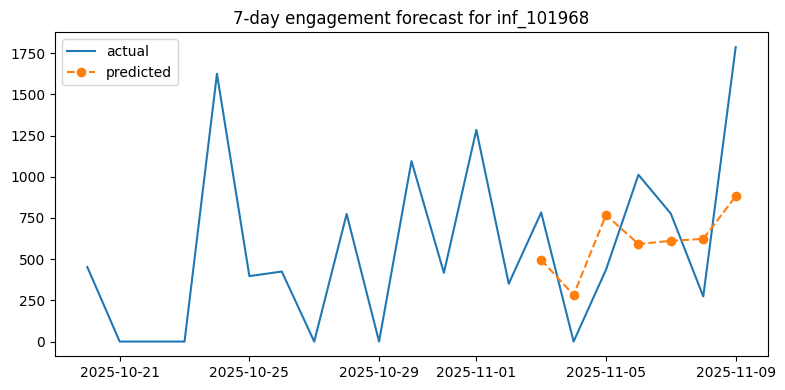

Lag feature importances (indicates what history matters most):


lag_1        0.219439
lag_7        0.195050
lag_14       0.185071
lag_2        0.164766
lag_3        0.134042
dayofweek    0.101633
dtype: float64

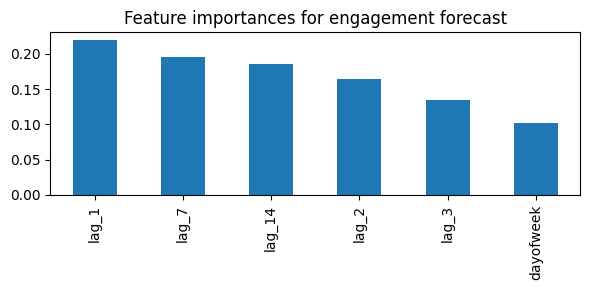

Content optimization suggestions:
- Top predictive features: ['lag_1', 'lag_7', 'lag_14'] — recent engagement matters most; keep posting cadence stable.
- Recommend prioritizing posts on 'Friday' based on historical engagement.


In [0]:
# UC5: Forecasting & Content Optimization (sample influencer)
posts = spark.table("influencer_capstone.posts_90d").toPandas()
posts['date'] = pd.to_datetime(posts['date'])
daily = posts.groupby(['influencer_id','date']).agg({'likes':'sum','comments':'sum','views':'sum'}).reset_index()
daily['engagement'] = daily['likes'] + daily['comments']

# choose a sample influencer with >=30 days
counts = daily['influencer_id'].value_counts()
candidate = counts[counts >= 30].index.tolist()
if len(candidate)==0:
    sample_inf = daily['influencer_id'].iloc[0]
else:
    sample_inf = candidate[0]

series = daily[daily['influencer_id']==sample_inf].set_index('date').resample('D').sum().fillna(0).reset_index()

# lag features
lags = [1,2,3,7,14]
for lag in lags:
    series[f'lag_{lag}'] = series['engagement'].shift(lag).fillna(0)
series['dayofweek'] = series['date'].dt.dayofweek

# train on all but last 7 days, test last 7 days
if len(series) < 21:
    raise RuntimeError("Not enough time series length for forecasting demo (need >=21 days).")
train = series.iloc[:-7]
test = series.iloc[-7:]
features = [f'lag_{l}' for l in lags] + ['dayofweek']

gbr = GradientBoostingRegressor(n_estimators=200, max_depth=4, random_state=42)
gbr.fit(train[features], train['engagement'])
pred = gbr.predict(test[features])
mae = mean_absolute_error(test['engagement'], pred)
print(f"Forecast MAE for influencer {sample_inf}: {mae:.2f}")

# plot actual vs predicted (last 21 days)
plt.figure(figsize=(8,4))
plt.plot(series['date'][-21:], series['engagement'][-21:], label='actual')
plt.plot(test['date'], pred, label='predicted', linestyle='--', marker='o')
plt.title(f"7-day engagement forecast for {sample_inf}")
plt.legend()
plt.tight_layout()
display(plt.gcf())
plt.close()

# content optimization hint: feature importances
feat_imp = pd.Series(gbr.feature_importances_, index=features).sort_values(ascending=False)
print("Lag feature importances (indicates what history matters most):")
display(feat_imp)

plt.figure(figsize=(6,3))
feat_imp.plot(kind='bar')
plt.title('Feature importances for engagement forecast')
plt.tight_layout()
display(plt.gcf())
plt.close()

# simple textual recommendations based on model/series
recommendations = []
top_feats = feat_imp.head(3).index.tolist()
recommendations.append(f"Top predictive features: {top_feats} — recent engagement matters most; keep posting cadence stable.")
if 'dayofweek' in feat_imp.index and feat_imp['dayofweek'] > 0.05:
    best_day = series.groupby(series['date'].dt.day_name())['engagement'].mean().sort_values(ascending=False).index[0]
    recommendations.append(f"Recommend prioritizing posts on '{best_day}' based on historical engagement.")
else:
    recommendations.append("No strong day-of-week effect detected; focus on content quality and timing consistency.")
print("Content optimization suggestions:")
for r in recommendations:
    print("-", r)


In [0]:
posts = spark.table("influencer_capstone.posts_90d").toPandas()
posts['date'] = pd.to_datetime(posts['date'])
daily = posts.groupby(['influencer_id','date']).agg({'likes':'sum','comments':'sum','views':'sum'}).reset_index()
daily['engagement'] = daily['likes'] + daily['comments']


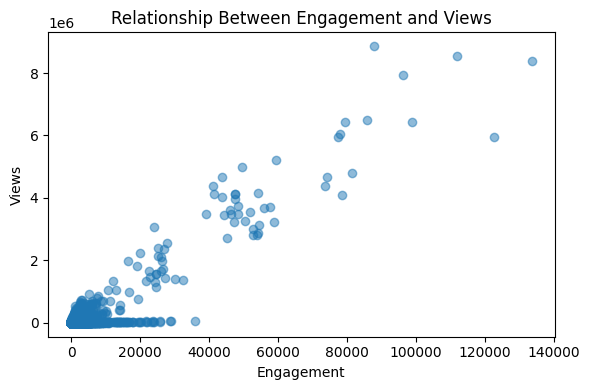

In [0]:
plt.figure(figsize=(6,4))
plt.scatter(daily['engagement'], daily['views'], alpha=0.5)
plt.xlabel('Engagement')
plt.ylabel('Views')
plt.title('Relationship Between Engagement and Views')
plt.tight_layout()
display(plt.gcf())
plt.close()
